# **Stock Sentiment**

## 0. Imports

In [20]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import gensim.downloader

os.chdir("../scripts")
from constants import TRAIN_DATA,  TEST_DATA, LABELS
from aux_funcs import preprocess, eval_sklearn_model, eval_lstm_model
os.chdir("../classes")
from word2vec import Word2Vec

In [2]:
# # Download NLTK resources
# nltk.download('stopwords')
# nltk.download('wordnet')

## 1. Data Loading

In [3]:
train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)

In [4]:
train_data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [5]:
test_data.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


## 2. Data Exploration

In [6]:
# Checking for missing values
train_data.isna().sum()

text     0
label    0
dtype: int64

There are no missing values in the dataset, so it is safe to proceed.

### 2.1. Text Feature

#### 2.1.1. Word Count

Start by spliting `text` into tokens and analysing the number of tokens in each document.

In [7]:
# Fetch wordcount for each document
train_data['word_count']  = train_data['text'].apply(lambda x: len(str(x).split(" ")))
train_data[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


#### 2.1.2. Descriptive Statistics

In [8]:
train_data['word_count'].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

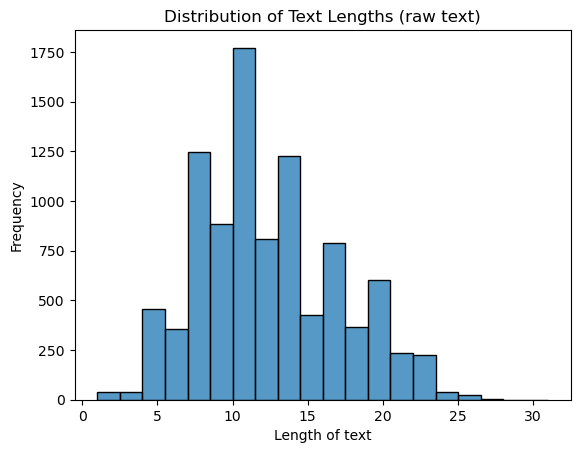

In [9]:
#Plot distribution of text length
sns.histplot(train_data['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [10]:
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

From the table above, "the" and "The" are both words in the top 10 - this could indicate a beneficial effect of lowercasing the 'text' feature.<br>
Also, "-" is a very common symbol which has no meaning and should be removed from the feature.

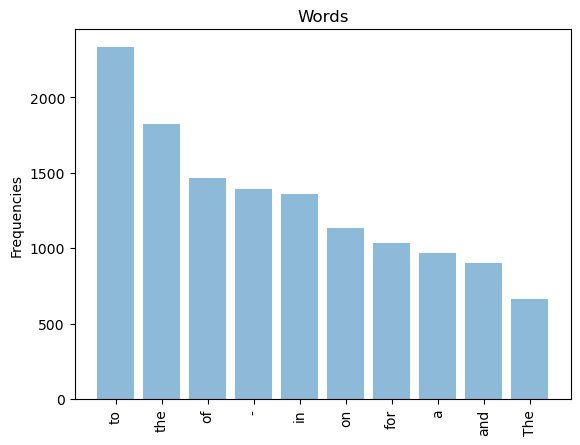

In [11]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

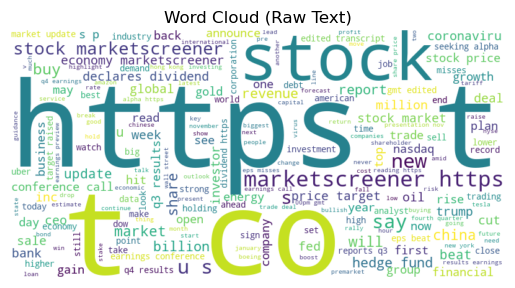

In [12]:
# Create a word cloud from the raw text
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

### 2.2. Target Feature

In [13]:
train_data['label'].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

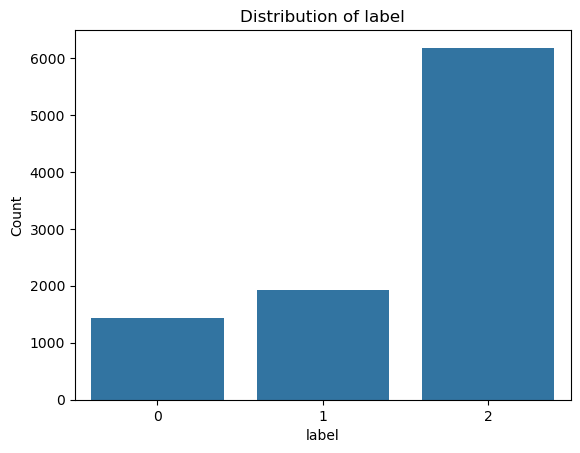

In [14]:
# Visualize distribution of satisfaction
sns.countplot(data=train_data, x='label')
plt.title("Distribution of label")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

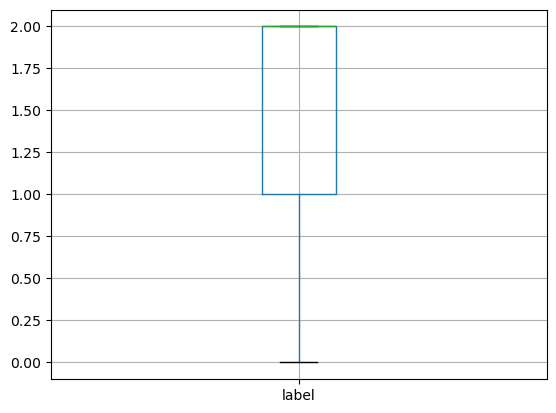

In [15]:
train_data.boxplot(['label'])
plt.show()

## 3. Data Preprocessing

In [16]:
y_train = train_data['label']
X_train = preprocess(
    dataframe=train_data
    ,col_name='text'
    ,keep_url=False
    ,lemmatize=True
    ,stemmize=False
)['text']

100%|██████████| 9543/9543 [00:03<00:00, 2816.38it/s]


In [17]:
X_test = preprocess(
    dataframe=test_data
    ,col_name='text'
    ,keep_url=False
    ,lemmatize=True
    ,stemmize=False
)['text']

100%|██████████| 2388/2388 [00:00<00:00, 19947.30it/s]


## 4. Feature Engineering

In [18]:
# Bag of Words
bow = CountVectorizer(binary=True)  # using binary=True, because working with short text

In [21]:
# Word2Vec
emb_size = 100
w2v_model = gensim.downloader.load(f'glove-twitter-{emb_size}')
w2v = Word2Vec(w2v_model)

In [22]:
# Transoformer (encoder)
transf = None

## 5. Modelling

In [23]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=20)

### 5.1. KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')    

#### Bag of Words

In [25]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=bow
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [26]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.6364    0.3447    0.4471      1442
     Bullish     0.6052    0.5309    0.5657      1923
     Neutral     0.7939    0.9092    0.8477      6178

    accuracy                         0.7477      9543
   macro avg     0.6785    0.5949    0.6202      9543
weighted avg     0.7321    0.7477    0.7303      9543



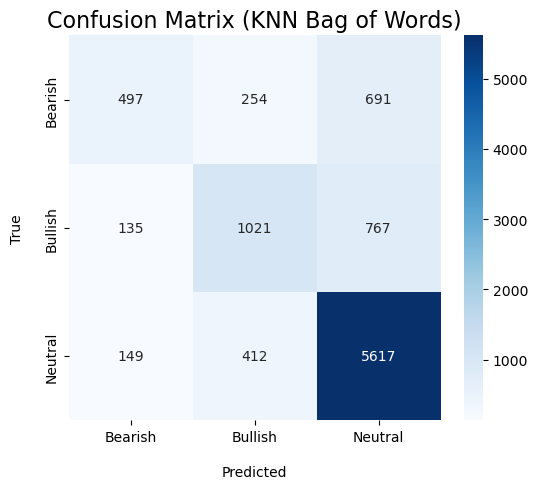

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Bag of Words)', fontsize=16)
plt.show()

#### Word2Vec

In [28]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=w2v
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [29]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.5254    0.2441    0.3333      1442
     Bullish     0.5469    0.4821    0.5124      1923
     Neutral     0.7793    0.9055    0.8377      6178

    accuracy                         0.7202      9543
   macro avg     0.6172    0.5439    0.5611      9543
weighted avg     0.6941    0.7202    0.6959      9543



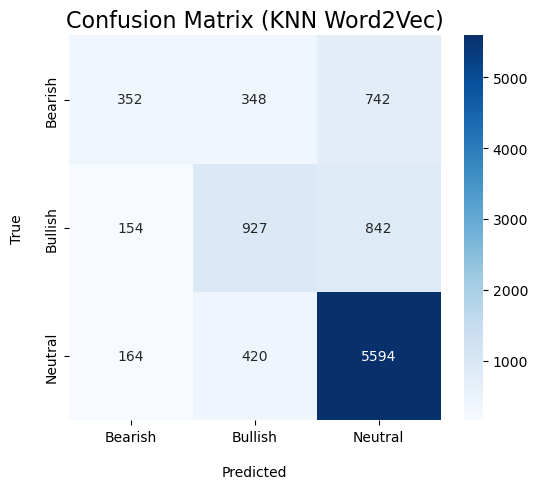

In [30]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Word2Vec)', fontsize=16)
plt.show()

### 5.2. LSTM

In [31]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    vectorizer=w2v_model
    ,emb_size=emb_size
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

100%|██████████| 4772/4772 [00:00<00:00, 47821.18it/s]
E0000 00:00:1748457522.040933   49820 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748457522.042016   49820 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/2


2025-05-28 19:38:46.148684: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5786 - loss: 0.9198 - val_accuracy: 0.6955 - val_loss: 0.7369
Epoch 2/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7268 - loss: 0.6762 - val_accuracy: 0.7207 - val_loss: 0.6879
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


100%|██████████| 4771/4771 [00:00<00:00, 30276.89it/s]


Epoch 1/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6089 - loss: 0.8889 - val_accuracy: 0.6973 - val_loss: 0.7238
Epoch 2/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7121 - loss: 0.6890 - val_accuracy: 0.7242 - val_loss: 0.6749
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [32]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.5865    0.2282    0.3285      1442
     Bullish     0.6293    0.4113    0.4975      1923
     Neutral     0.7474    0.9346    0.8306      6178

    accuracy                         0.7224      9543
   macro avg     0.6544    0.5247    0.5522      9543
weighted avg     0.6993    0.7224    0.6876      9543



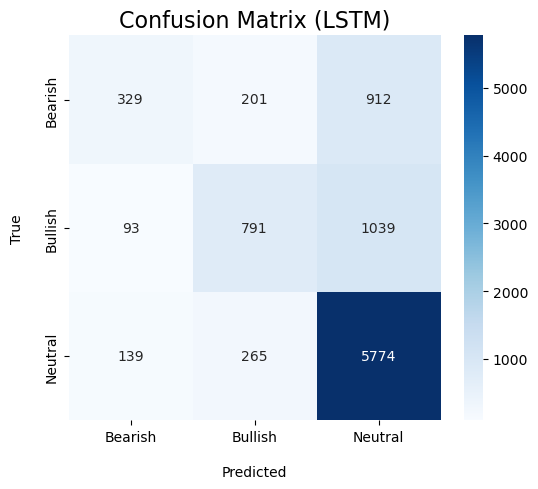

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM)', fontsize=16)
plt.show()

In [34]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

,fold,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1,0.653532,0.822676,0.695516,0.736880
1,0,2,0.730455,0.668082,0.720662,0.687945
2,1,1,0.652137,0.819864,0.697338,0.723802
3,1,2,0.720872,0.685543,0.724167,0.674892


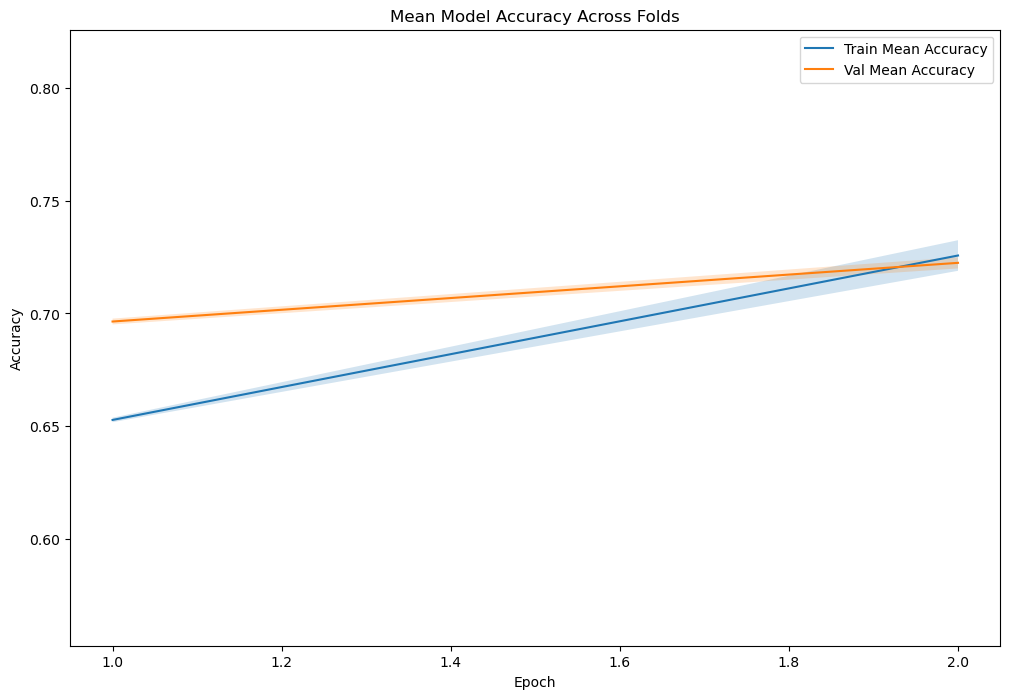

In [35]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.3. Transformer